In [1]:
# # this block of code imports graphical libraries for plotting graphs with high resolution
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 120

In [2]:
# Libraries of functions need to be imported
import numpy as np
import pandas as pd
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.spatial import Delaunay
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import mean_squared_error as mse
from scipy import linalg
from scipy.interpolate import interp1d, LinearNDInterpolator, NearestNDInterpolator
from sklearn.decomposition import PCA

# the following line(s) are necessary if you want to make SKlearn compliant functions
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted

In [3]:
# Gaussian Kernel
def Gaussian(x):
  return np.where(np.abs(x)>4,0,1/(np.sqrt(2*np.pi))*np.exp(-1/2*x**2))

In [4]:
# this is the correct vectorized version
def Tricubic(x):
  return np.where(np.abs(x)>1,0,(1-np.abs(x)**3)**3)

In [5]:
# Epanechnikov Kernel
def Epanechnikov(x):
  return np.where(np.abs(x)>1,0,3/4*(1-np.abs(x)**2))

In [6]:
# Quartic Kernel
def Quartic(x):
  return np.where(np.abs(x)>1,0,15/16*(1-np.abs(x)**2)**2)

# Learning Objectives

-  How to efficiently compute all the pairwise distances among different observations.
- How to use the weights with the distances.
- Test the locally weighted regressors.
- We want to see how to boost their performance; this means boosting, such as gradient boosting.

In [7]:
# real data application includes cars.csv, concrete.csv and more
data = pd.read_csv('cars.csv')

In [8]:
data

,MPG,CYL,ENG,WGT
0,18.0,8,307.0,3504
1,15.0,8,350.0,3693
2,18.0,8,318.0,3436
3,16.0,8,304.0,3433
4,17.0,8,302.0,3449
...,...,...,...,...
387,27.0,4,140.0,2790
388,44.0,4,97.0,2130
389,32.0,4,135.0,2295
390,28.0,4,120.0,2625


In [9]:
x = data.drop(columns=['MPG']).values
y = data['MPG'].values

## Compute all pairwise distances efficiently

This means we build a general case, assuming two matrices, we want to compute all the pairwise distances between the rows of matrix 1 and the rows of matrix 2.

In [10]:
# we want the Euclidean distance
u = np.array(np.random.uniform(2,5,5))
v = np.array(np.random.uniform(1,2,5))

In [11]:
u

array([3.11136394, 4.70201595, 3.24921825, 3.15282664, 2.40492934])

In [12]:
v

array([1.02179092, 1.53245609, 1.06868792, 1.55851531, 1.41797694])


$$\large \text{dist}\left(\vec{u},\vec{v}\right):= \sqrt{\sum(u_i-v_i)^2}$$

In [13]:
np.sqrt(np.sum((u-v)**2))

4.76267165301773

In [14]:
# what happens if u is matrix that has n rows and 5 columns?
u = np.random.uniform(2,5,(10,5))

In [15]:
# check the shape
u.shape

(10, 5)

In [16]:
v.shape # this may create a problem

(5,)

In [17]:
# let's show a simple code
def dist(u,v):
  return np.sqrt(np.sum((u-v)**2,axis=1))

In [18]:
dist(u,v)

array([4.95249469, 5.42679599, 6.33198239, 5.83353537, 5.68509162,
       4.35254831, 4.63534474, 5.90778217, 4.37502843, 6.25589462])

In [19]:
# how about the case when v is a matrix with 5 columns?
def dist(u,v):
  D = []
  if len(v.shape)==1:
    v = v.reshape(1,-1)
  # we would like all the pairwise combinations if u and v are matrices
  # we could avoid two for loops if we consider broadcasting
  for rowj in v:
    D.append(np.sqrt(np.sum((u-rowj)**2,axis=1)))
  return np.array(D).T

In [20]:
dist(u,v)

array([[4.95249469],
       [5.42679599],
       [6.33198239],
       [5.83353537],
       [5.68509162],
       [4.35254831],
       [4.63534474],
       [5.90778217],
       [4.37502843],
       [6.25589462]])

In [21]:
v = np.random.uniform(1,2,(20,5))

In [22]:
D = dist(u,v)

In [23]:
D.shape

(10, 20)

In [24]:
D

array([[4.77470757, 4.53626408, 5.24006051, 4.88394044, 4.26052637,
        3.97365361, 4.51255447, 4.07303599, 4.83508322, 4.11794576,
        4.47078512, 4.81568098, 4.11530477, 4.71438514, 4.35968485,
        4.87039695, 4.63081126, 4.34796676, 5.0113093 , 4.21968471],
       [5.67625221, 5.19130762, 5.82865542, 5.55040927, 5.07085953,
        4.74947946, 5.13710376, 4.73038387, 5.2454422 , 4.67648311,
        5.259598  , 5.18145779, 4.85327582, 5.4471428 , 4.79164477,
        5.38282737, 5.22345454, 5.24128275, 5.35447564, 4.85768938],
       [6.32475834, 5.6905659 , 6.36536444, 6.22640107, 5.39591445,
        5.43792727, 5.82116097, 5.44778081, 5.88062481, 5.67078367,
        6.00622236, 5.80279366, 5.56062543, 5.88029955, 5.53040285,
        6.21833519, 5.6384961 , 6.03924268, 6.187645  , 5.59231473],
       [5.9337352 , 5.40270106, 6.1633008 , 5.79943285, 5.13708739,
        5.11016567, 5.426692  , 5.01981358, 5.5950188 , 5.25560188,
        5.57505639, 5.65253776, 5.23268792, 5

In [25]:
def weight_function(u,v,kern=Gaussian,tau=0.5):
    return kern(dist(u,v)/(2*tau))

In [26]:
W = weight_function(u,v,kern=Tricubic,tau=1.7)

In [45]:
# we show now the effect of scaling onto the data
scale = MinMaxScaler()
uscaled = scale.fit_transform(u)
vscaled = scale.fit_transform(v)
vscaled

array([[0.0231251 , 0.        , 0.90443941, 0.20424563, 0.23922863],
       [1.        , 0.20471704, 0.23815418, 0.71029072, 0.53847816],
       [0.76962649, 0.19801191, 0.        , 0.        , 0.13220805],
       [0.        , 0.24773873, 0.43096073, 0.27037417, 0.6367169 ],
       [0.74297628, 0.25451591, 0.88062674, 0.39831947, 0.98422088],
       [0.9199994 , 0.56252417, 1.        , 0.84899893, 0.25355395],
       [0.75114213, 0.28413199, 0.22144002, 0.88374804, 0.4184896 ],
       [0.48454956, 0.67715913, 0.88248764, 0.75773795, 0.73977688],
       [0.56343714, 0.76954956, 0.2154109 , 0.18538725, 0.69504191],
       [0.70547093, 0.94354214, 0.83361738, 0.93906224, 0.        ],
       [0.22021894, 0.30232488, 0.82087204, 0.54318211, 0.32374482],
       [0.99083344, 1.        , 0.32869955, 0.0589158 , 0.34078745],
       [0.8335315 , 0.56983928, 0.91338187, 0.74410009, 0.22643237],
       [0.7978185 , 0.00697499, 0.28087462, 0.45756074, 0.58271224],
       [0.78998617, 0.67525158, 0.

In [28]:
W = weight_function(uscaled,vscaled,kern=Tricubic,tau=0.35)

In [29]:
class Lowess:
    def __init__(self, kernel = Gaussian, tau=0.05):
        self.kernel = kernel
        self.tau = tau

    def fit(self, x, y):
        kernel = self.kernel
        tau = self.tau
        self.xtrain_ = x
        self.yhat_ = y

    def predict(self, x_new):
        check_is_fitted(self)
        x = self.xtrain_
        y = self.yhat_
        lm = linear_model.Ridge(alpha=0.001)
        w = weight_function(x,x_new,self.kernel,self.tau)

        if np.isscalar(x_new):
          lm.fit(np.diag(w)@(x.reshape(-1,1)),np.diag(w)@(y.reshape(-1,1)))
          yest = lm.predict([[x_new]])[0][0]
        else:
          n = len(x_new)
          yest_test = np.zeros(n)
          #Looping through all x-points
          for i in range(n):
            lm.fit(np.diag(w[:,i])@x,np.diag(w[:,i])@y)
            yest_test[i] = lm.predict(x_new[i].reshape(1,-1))
        return yest_test

In [30]:
model = Lowess(kernel=Epanechnikov,tau=0.02)

In [46]:
xscaled = scale.fit_transform(x)
xscaled

array([[1.        , 0.61757106, 0.5361497 ],
       [1.        , 0.72868217, 0.58973632],
       [1.        , 0.64599483, 0.51686986],
       ...,
       [0.2       , 0.17312661, 0.19336547],
       [0.2       , 0.13436693, 0.2869294 ],
       [0.2       , 0.13178295, 0.31386447]])

In [43]:
model.fit(xscaled,y)
model.predict(xscaled)

array([17.14728283, 16.25531338, 17.23587758, 17.36140295, 17.33488234,
       14.17189219, 14.03667363, 14.21044136, 13.85943883, 15.55357175,
       16.17119179, 16.56402105, 15.64846547, 14.14938007, 28.09964774,
       20.78917374, 20.68016351, 20.37236789, 30.52438598, 31.02755441,
       27.80746593, 28.64909554, 29.12040199, 27.50208472, 20.46885358,
       13.08466602, 13.92622066, 13.90255415, 12.23740013, 30.52438598,
       25.09687697, 28.43429847, 20.51048878, 19.29510412, 18.53066657,
       18.56809089, 19.28338204, 14.61453527, 13.79118638, 14.81198409,
       15.0816837 , 11.88187277, 12.77225297, 11.29981087, 18.96057223,
       24.68345931, 18.59720501, 18.84031272, 27.42441685, 28.35645661,
       32.98144881, 31.78176082, 34.57615718, 34.44194469, 31.02878846,
       31.59523198, 28.31394544, 30.47253648, 30.24327995, 24.68345931,
       27.40800258, 14.37416611, 14.05397316, 14.92713642, 14.90008572,
       16.68174692, 13.26971477, 13.48991788, 13.67199078, 13.93

In [33]:
yhat = model.predict(xscaled)

In [34]:
mse(yhat,y)

9.608473561664916

In [35]:
# we can try the "elbow" approach for tunning tau
taus = np.arange(0.01,0.25,0.01)

In [36]:
mse_list = []
for tau in taus:
  model = Lowess(kernel=Epanechnikov,tau=tau)
  model.fit(xscaled,y)
  yhat = model.predict(xscaled)
  mse_list.append(mse(yhat,y))

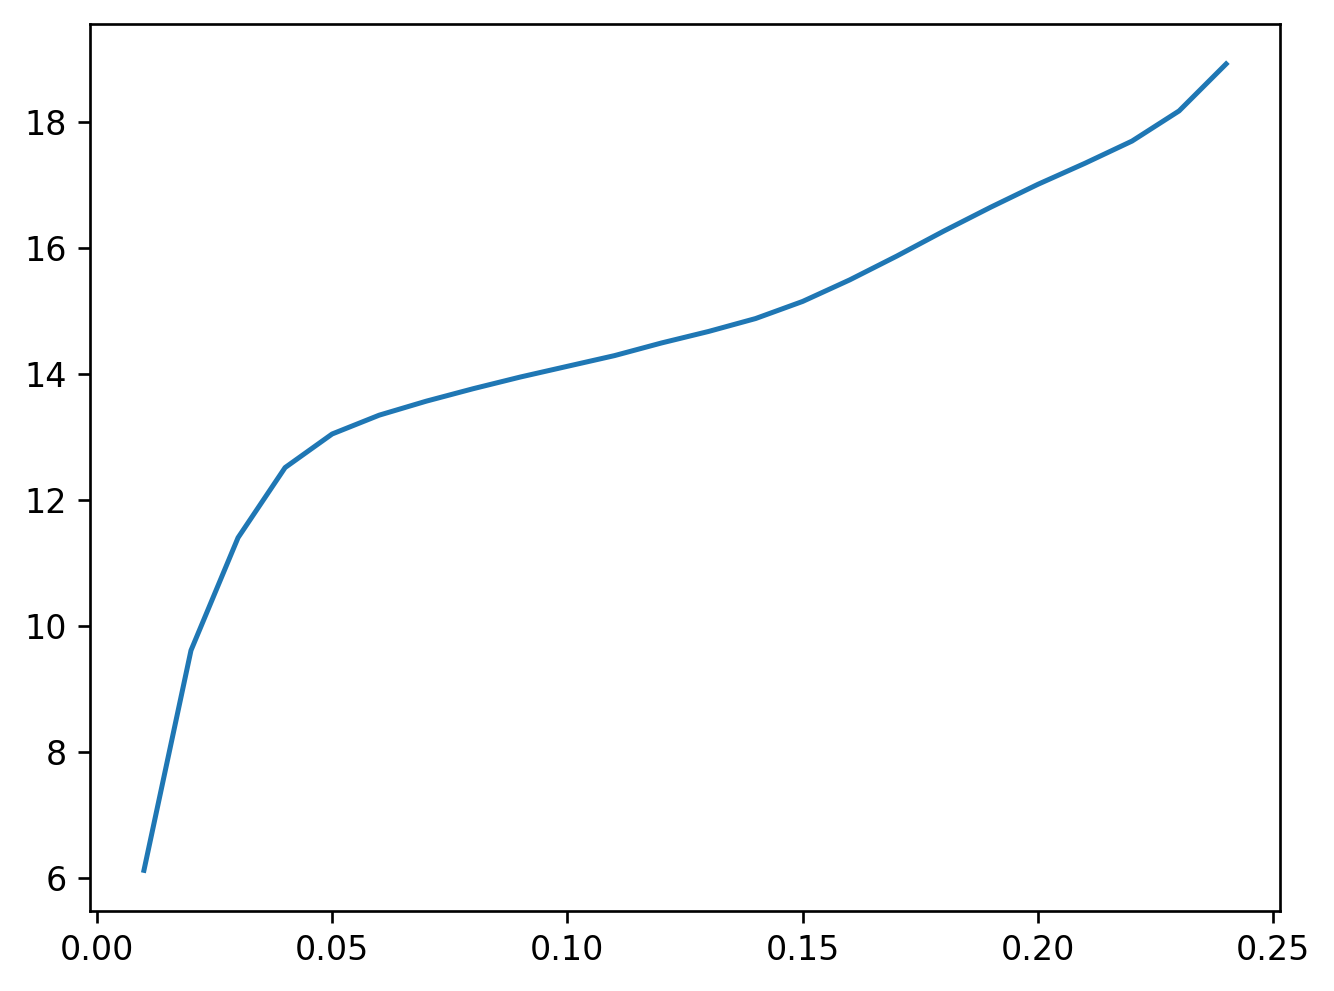

In [37]:
plt.plot(taus,mse_list)

In [38]:
mse_lwr = []
mse_rf = []
kf = KFold(n_splits=10,shuffle=True,random_state=1234)
model_rf = RandomForestRegressor(n_estimators=200,max_depth=7)
# model_lw = Lowess_AG_MD(f=1/3,iter=2,intercept=True)
model_lw = Lowess(kernel= Epanechnikov,tau=0.14)

for idxtrain, idxtest in kf.split(x):
  xtrain = x[idxtrain]
  ytrain = y[idxtrain]
  ytest = y[idxtest]
  xtest = x[idxtest]
  xtrain = scale.fit_transform(xtrain)
  xtest = scale.transform(xtest)

  model_lw.fit(xtrain,ytrain)
  yhat_lw = model_lw.predict(xtest)

  model_rf.fit(xtrain,ytrain)
  yhat_rf = model_rf.predict(xtest)

  mse_lwr.append(mse(ytest,yhat_lw))
  mse_rf.append(mse(ytest,yhat_rf))
print('The Cross-validated Mean Squared Error for Locally Weighted Regression is : '+str(np.mean(mse_lwr)))
print('The Cross-validated Mean Squared Error for Random Forest is : '+str(np.mean(mse_rf)))

The Cross-validated Mean Squared Error for Locally Weighted Regression is : 16.455751824170626
The Cross-validated Mean Squared Error for Random Forest is : 17.617112748974662


## Efficient Classes for Computing all the Pairwise Distances

### Scipy Classes

In [39]:
from scipy.spatial.distance import cdist




# Compute pairwise distances using Euclidean distance metric
pairwise_distances = cdist(xtrain, xtest, metric='euclidean')

print("Pairwise distances:")
print(pairwise_distances)

Pairwise distances:
[[0.02176528 0.97589949 1.07465667 ... 1.03367484 1.01079351 0.43947887]
 [0.14026861 1.04976726 1.15993053 ... 1.11468563 1.08905696 0.49942492]
 [0.03618592 0.98196775 1.08333189 ... 1.04113141 1.01752722 0.44213376]
 ...
 [0.96796902 0.0156773  0.15794466 ... 0.09154571 0.05475171 0.55698237]
 [0.95897078 0.11560343 0.19009382 ... 0.14837735 0.13319966 0.55417906]
 [0.95406098 0.14144446 0.21195662 ... 0.17423515 0.1604333  0.55106959]]


## Faiss

In [40]:
!pip install faiss-cpu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 9.9 MB/s eta 0:00:000m eta 0:00:010:01:01


In [41]:
import faiss

In [42]:
# Example vectors
vector1 = xtrain
vector2 = xtest

# Concatenate the vectors into a single array
all_vectors = np.concatenate((vector1, vector2), axis=0)

# Initialize Faiss index
d = all_vectors.shape[1]  # Dimension of vectors
index = faiss.IndexFlatL2(d)  # L2 distance (Euclidean distance)

# Add vectors to the index
index.add(all_vectors)

# Query for the nearest neighbors (in this case, excluding the vector itself)
k = all_vectors.shape[0] - 1  # Return distances to all other vectors
D, I = index.search(all_vectors, k)

# The first row of D corresponds to distances from vector1 to all vectors,
# and the second row corresponds to distances from vector2 to all vectors
pairwise_distances = D[1]

print("Pairwise distances:")
print(pairwise_distances)

Pairwise distances:
[0.00000000e+00 6.89029694e-05 8.41617584e-05 1.24669075e-03
 2.01201439e-03 3.51595879e-03 5.63931465e-03 5.67364693e-03
 6.98184967e-03 7.14087486e-03 7.15255737e-03 7.41600990e-03
 8.37707520e-03 8.65793228e-03 1.06999874e-02 1.07526779e-02
 1.18432045e-02 1.22568607e-02 1.24166012e-02 1.27058029e-02
 1.35922432e-02 1.39296055e-02 1.41646862e-02 1.41646862e-02
 1.52766705e-02 1.52938366e-02 1.54678822e-02 1.56049728e-02
 1.63900852e-02 1.66249275e-02 1.70717239e-02 1.73778534e-02
 1.74448490e-02 1.79543495e-02 1.82802677e-02 1.89366341e-02
 1.91261768e-02 1.94141865e-02 1.96754932e-02 2.00660229e-02
 2.01635361e-02 2.02689171e-02 2.18474865e-02 2.23650932e-02
 2.28676796e-02 2.32322216e-02 2.53779888e-02 2.58045197e-02
 2.71050930e-02 2.76982784e-02 3.11198235e-02 3.18522453e-02
 3.38265896e-02 3.49245071e-02 3.58791351e-02 3.65049839e-02
 3.68406773e-02 3.79137993e-02 3.87270451e-02 3.94816399e-02
 4.02293205e-02 4.47731018e-02 4.50217724e-02 4.51204777e-02
 4.5